In [99]:
import os
import numpy as np
import pandas as pd
#import piplite
%pip install --upgrade pandas bottleneck

#await piplite.install('seaborn')
#await piplite.install('plotly')

#%pip install --upgrade matplotlib

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from scipy import stats
%pip install pandas statsmodels scikit-learn
%pip install -- missingno
from pandas import DataFrame
import warnings

warnings.filterwarnings("ignore")
#set_config(display="diagram")
#%matplotlib inline
%reload_ext autoreload
%autoreload 

#sns.set_theme(style="darkgrid")
filepath = os.getcwd()
print(filepath)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
/Users/jmgerie/Desktop/ML/module 11


In [100]:
ca_vehicles =  pd.read_csv('ca_vehicles.csv')
ca_vehicles.head()

,Unnamed: 0,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color
0,21171,16990,2018.0,hyundai,accent se sedan 4d,good,gas,16930.0,clean,other,sedan,white
1,21172,3700,2004.0,toyota,highlander,good,gas,142000.0,clean,automatic,NaN,NaN
2,21173,0,2019.0,mercedes-benz,sprinter box truck,NaN,diesel,4074.0,clean,automatic,NaN,white
3,21174,11975,2003.0,harley-davidson,davidson,excellent,gas,207000.0,clean,automatic,pickup,black
4,21175,0,2014.0,nissan,rogue,NaN,gas,47287.0,clean,automatic,SUV,white


In [101]:
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50614 entries, 0 to 50613
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    50614 non-null  int64  
 1   price         50614 non-null  int64  
 2   year          50498 non-null  float64
 3   manufacturer  48559 non-null  object 
 4   model         49995 non-null  object 
 5   condition     33104 non-null  object 
 6   fuel          50547 non-null  object 
 7   odometer      49456 non-null  float64
 8   title_status  48994 non-null  object 
 9   transmission  50379 non-null  object 
 10  type          41079 non-null  object 
 11  paint_color   33828 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 4.6+ MB


In [102]:
ca_vehicles = ca_vehicles.drop("Unnamed: 0", axis = 1)

<Axes: >

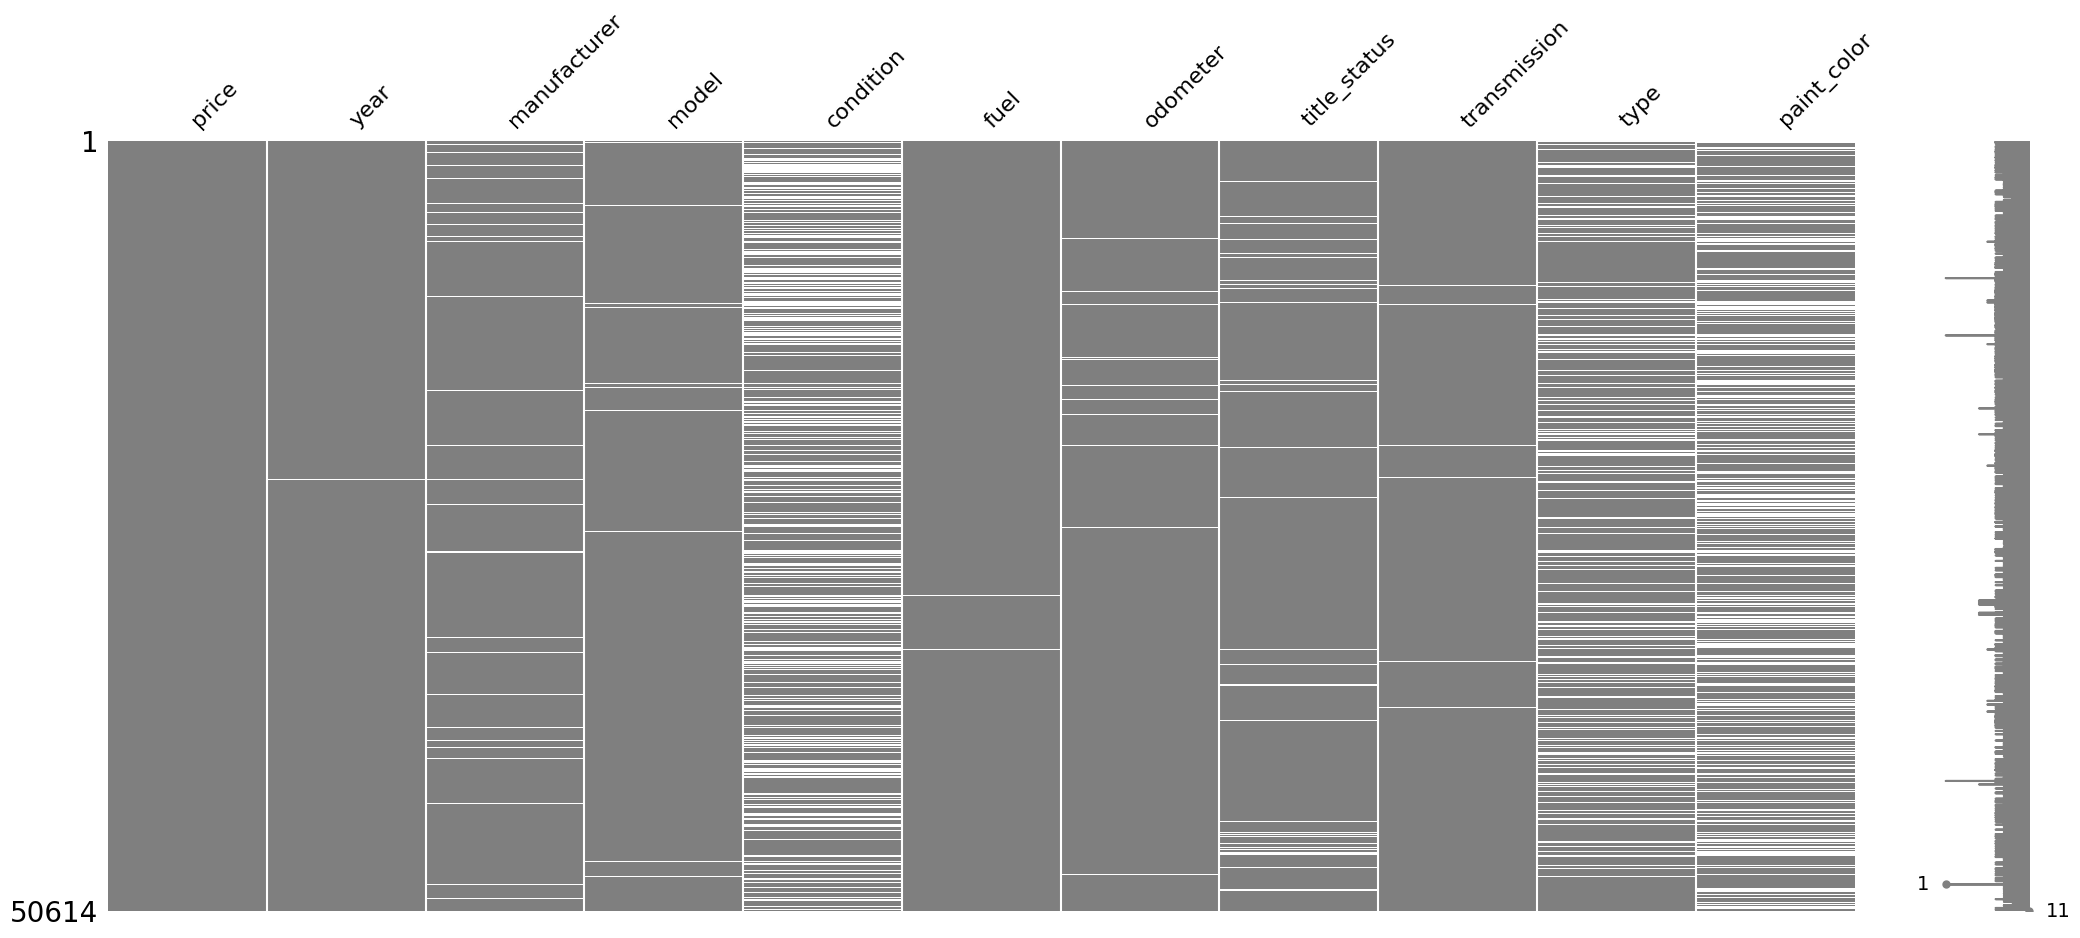

In [103]:
#visualizing the location of "missing data"
import missingno as msno
msno.matrix(ca_vehicles, color = (0.5, 0.5, 0.5))

In [104]:
ca_vehicles['price'].describe()

count    5.061400e+04
mean     1.201211e+05
std      1.509054e+07
min      0.000000e+00
25%      5.500000e+03
50%      1.299000e+04
75%      2.498100e+04
max      3.009549e+09
Name: price, dtype: float64

In [105]:
#dropping Harley-Davidson since it is a motrocycle brand not a car.
ca_vehicles = ca_vehicles[ca_vehicles["manufacturer"] != "harley-davidson"]

#dropping the rows with "NaN" values in the manufacturer column
ca_vehicles.dropna(subset=['manufacturer'], inplace=True)
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48538 entries, 0 to 50613
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         48538 non-null  int64  
 1   year          48538 non-null  float64
 2   manufacturer  48538 non-null  object 
 3   model         47924 non-null  object 
 4   condition     31745 non-null  object 
 5   fuel          48492 non-null  object 
 6   odometer      47455 non-null  float64
 7   title_status  46933 non-null  object 
 8   transmission  48365 non-null  object 
 9   type          39696 non-null  object 
 10  paint_color   32458 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 4.4+ MB


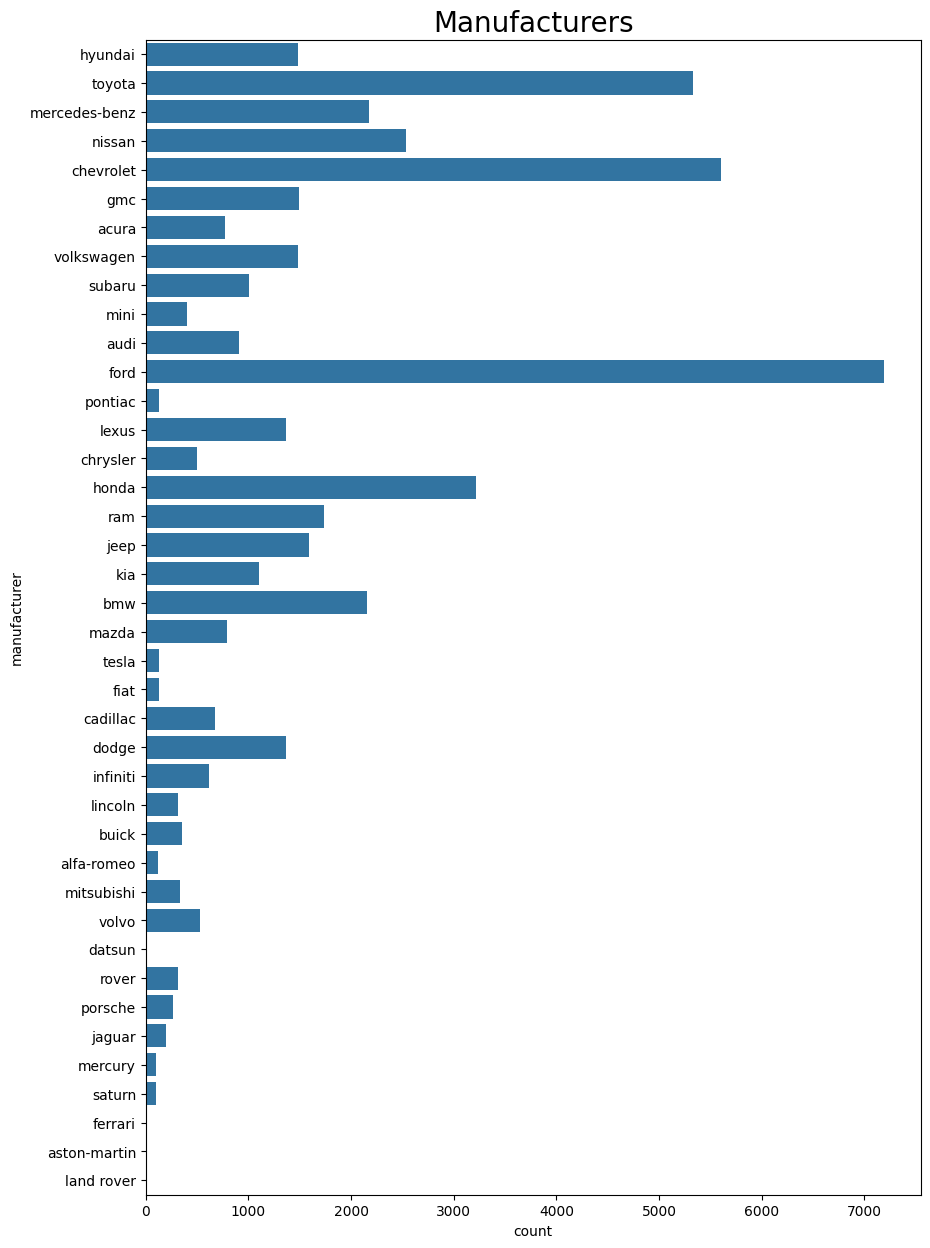

In [106]:
#visualizing the price column
plt.figure(figsize = (10, 15))
sns.countplot(y = ca_vehicles.manufacturer)
plt.title("Manufacturers", fontsize = 20)
plt.show()

In [107]:
#dropping the rows where price isless than 500 and price is ove 400,000
ca_vehicles = ca_vehicles[(ca_vehicles['price'] > 500)] 
ca_vehicles = ca_vehicles[(ca_vehicles['price'] < 400000)]

In [108]:
#checking to the column
ca_vehicles['price'].describe()

count     42072.000000
mean      19074.637645
std       15017.695341
min         501.000000
25%        8299.000000
50%       15487.000000
75%       26500.000000
max      349999.000000
Name: price, dtype: float64

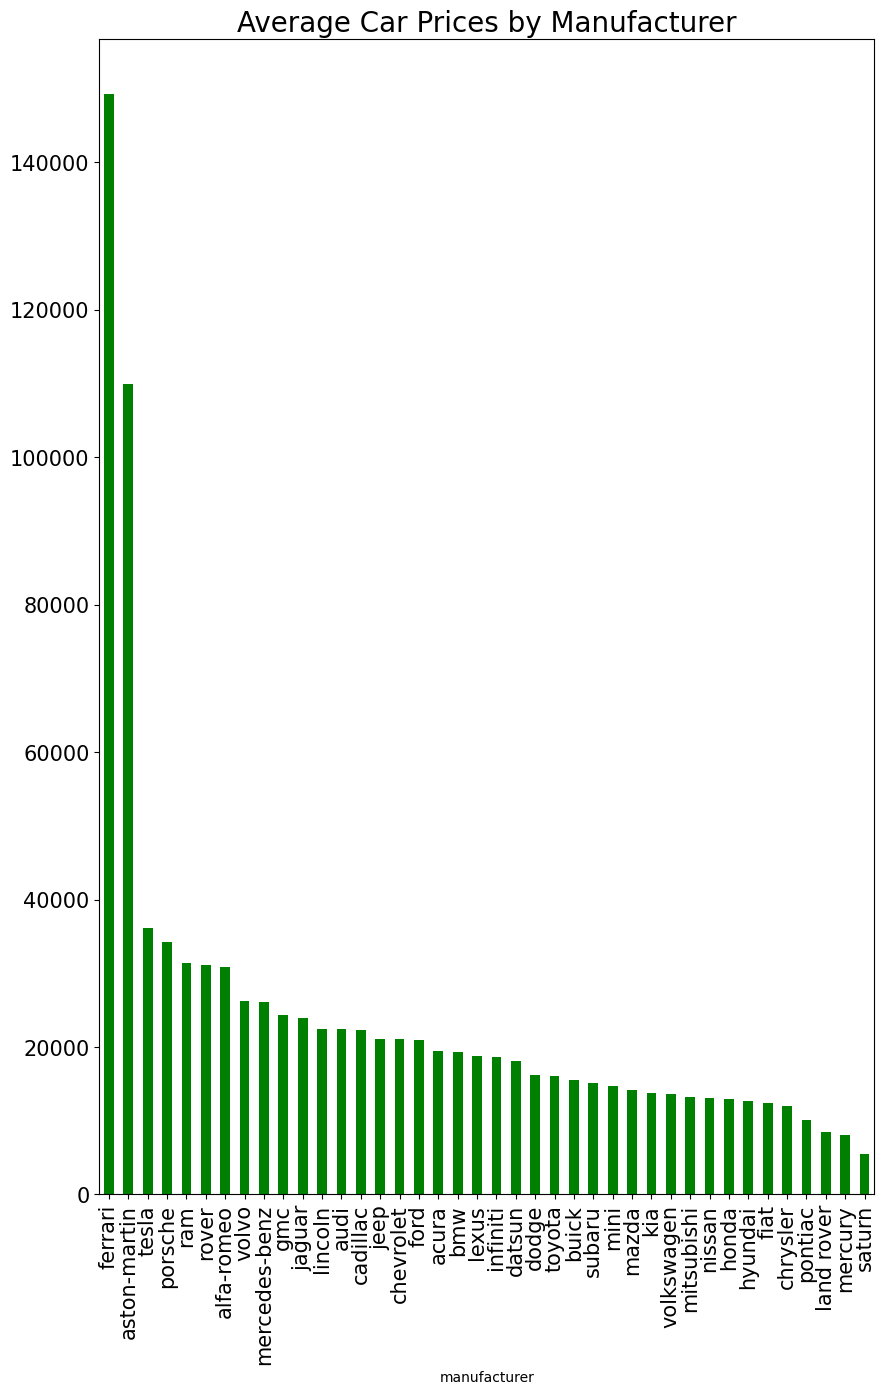

In [109]:
import matplotlib.pyplot as plt
# Create a new figure with the specified figsize
plt.figure(figsize = (10, 15))

# Group by "manufacturer" and calculate the mean price for each group
ca_vehicles.groupby("manufacturer")["price"].mean().sort_values(ascending=False).plot(kind="bar", fontsize=15, color="green")
plt.title("Average Car Prices by Manufacturer", fontsize=20)

# manufacturer_mean_price = ca_vehicles.groupby("manufacturer")["price"].mean()
# Show the plot
plt.show()

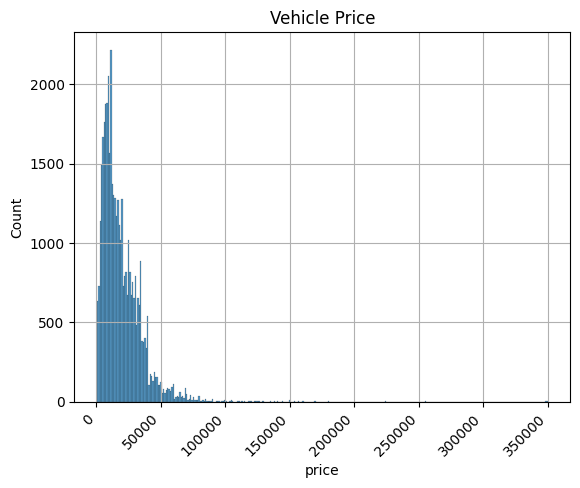

In [110]:
# APlotting vehicles  Prices
sns.histplot(data=ca_vehicles["price"])
plt.title('Vehicle Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

In [111]:
#ca_vehicles["price"] = np.log(ca_vehicles["price"])

In [112]:
# Apply Box-Cox transformation to column 'price' to reuce the variance
transformed_A, lambda_A = stats.boxcox(ca_vehicles['price'].dropna())  # Dropna to remove missing values before transformation
ca_vehicles['price'] = stats.boxcox(ca_vehicles['price'], lmbda=lambda_A)

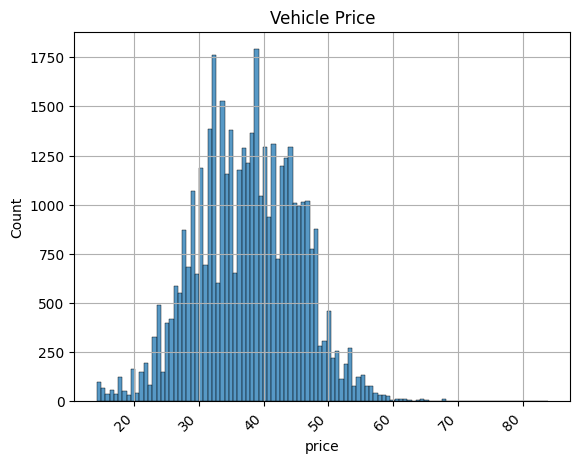

In [113]:
# APlotting vehicles  Prices
sns.histplot(data=ca_vehicles["price"])
plt.title('Vehicle Price')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

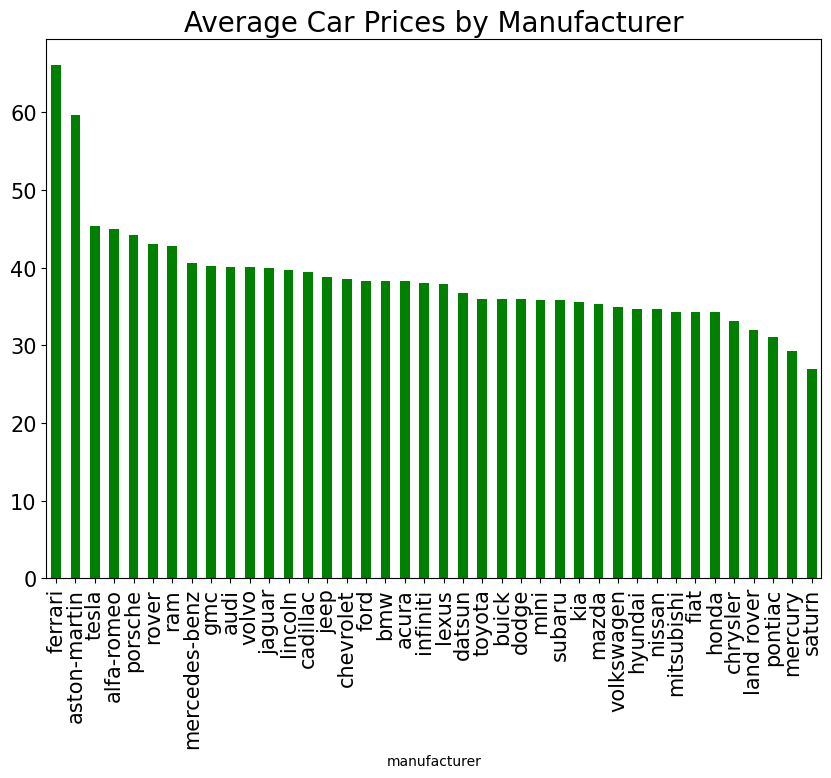

In [114]:
#visualizing the variance reduction after Box-Cox treatment on price Vs manufacturers

import matplotlib.pyplot as plt
# Create a new figure with the specified figsize
plt.figure(figsize = (10, 7))

# Group by "manufacturer" and calculate the mean price for each group
ca_vehicles.groupby("manufacturer")["price"].mean().sort_values(ascending=False).plot(kind="bar", fontsize=15, color="green")
plt.title("Average Car Prices by Manufacturer", fontsize=20)

# Show the plot
plt.show()


In [115]:
# undrstanding the "model" colums
ca_vehicles['model'].value_counts()

model
f-150                 489
accord                431
civic                 392
tacoma                379
camry                 370
                     ... 
428i convertible        1
envoy denali            1
2500hd duramax          1
express 1500 cargo      1
cherokee altitude       1
Name: count, Length: 6674, dtype: int64

In [116]:
# Clean the model names
ca_vehicles['model_clean'] = ca_vehicles['model'].str.lower().str.strip().str.split().str[0]


#droping the model column and replacing it with the new cleaned column
ca_vehicles = ca_vehicles.drop("model", axis = 1)
ca_vehicles = ca_vehicles.rename(columns={"model_clean": "model"})

#dropping the rows with "NaN" values in the manufacturer column
ca_vehicles.dropna(subset=['model'], inplace=True)
ca_vehicles.info()

#testing the column
print(ca_vehicles['model'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 41618 entries, 0 to 50613
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         41618 non-null  float64
 1   year          41618 non-null  float64
 2   manufacturer  41618 non-null  object 
 3   condition     29890 non-null  object 
 4   fuel          41573 non-null  object 
 5   odometer      40837 non-null  float64
 6   title_status  40272 non-null  object 
 7   transmission  41493 non-null  object 
 8   type          34167 non-null  object 
 9   paint_color   28997 non-null  object 
 10  model         41618 non-null  object 
dtypes: float64(3), object(8)
memory usage: 3.8+ MB
model
silverado    1493
civic         848
accord        826
tacoma        777
f-150         694
             ... 
step            1
p100d           1
impeza          1
montana         1
d250            1
Name: count, Length: 1279, dtype: int64


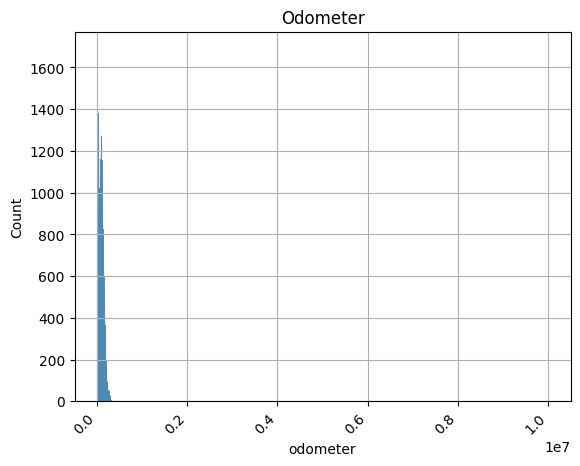

count    4.083700e+04
mean     9.413408e+04
std      1.528777e+05
min      0.000000e+00
25%      4.026300e+04
50%      8.600000e+04
75%      1.305200e+05
max      1.000000e+07
Name: odometer, dtype: float64

In [117]:
#understanding Odometer column
# APlotting vehicles  Odometer
sns.histplot(data=ca_vehicles["odometer"])
plt.title('Odometer')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

ca_vehicles['odometer'].describe()

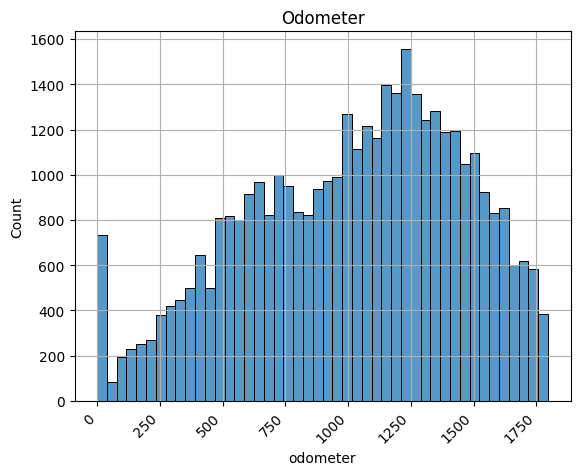

count    38565.000000
mean      1019.437182
std        431.427542
min          0.000000
25%        696.144892
50%       1074.233071
75%       1356.014209
max       1796.052597
Name: odometer, dtype: float64

In [118]:
#dropping odometer values over 200K to same memory and better data accuracy
ca_vehicles = ca_vehicles[(ca_vehicles['odometer'] < 200000)]


# Remove rows with NaN values in the 'odometer' column
ca_vehicles = ca_vehicles.dropna(subset=['odometer'])

# Replace '0' values with '1' in the 'odometer' column
ca_vehicles['odometer'] = ca_vehicles['odometer'].replace(0, 1)

# Apply Box-Cox transformation to column 'odometer' to reduce the variance
transformed_odometer, lambda_odometer = stats.boxcox(ca_vehicles['odometer'])

# Update the 'odometer' column with the transformed values
ca_vehicles['odometer'] = transformed_odometer

# APlotting vehicles  Prices
sns.histplot(data=ca_vehicles["odometer"])
plt.title('Odometer')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

ca_vehicles['odometer'].describe()

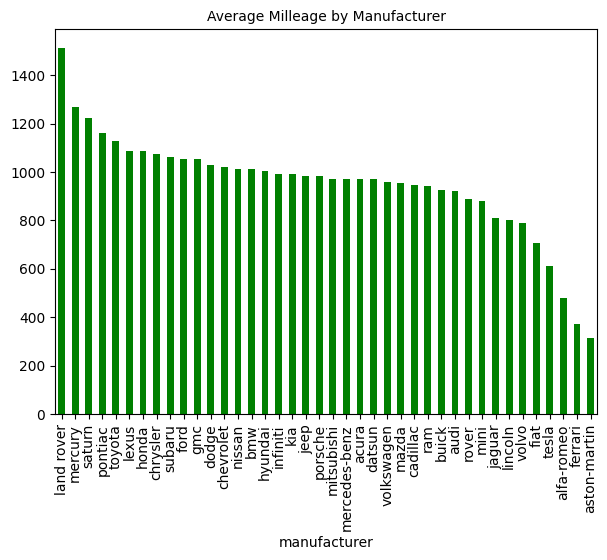

In [119]:
# Create a new figure with the specified figsize
plt.figure(figsize = (7, 5))

# Group by "manufacturer" and calculate the mean price for each group
ca_vehicles.groupby("manufacturer")["odometer"].mean().sort_values(ascending=False).plot(kind="bar", fontsize=10, color="green")
plt.title("Average Milleage by Manufacturer", fontsize=10)

# Show the plot
plt.show()

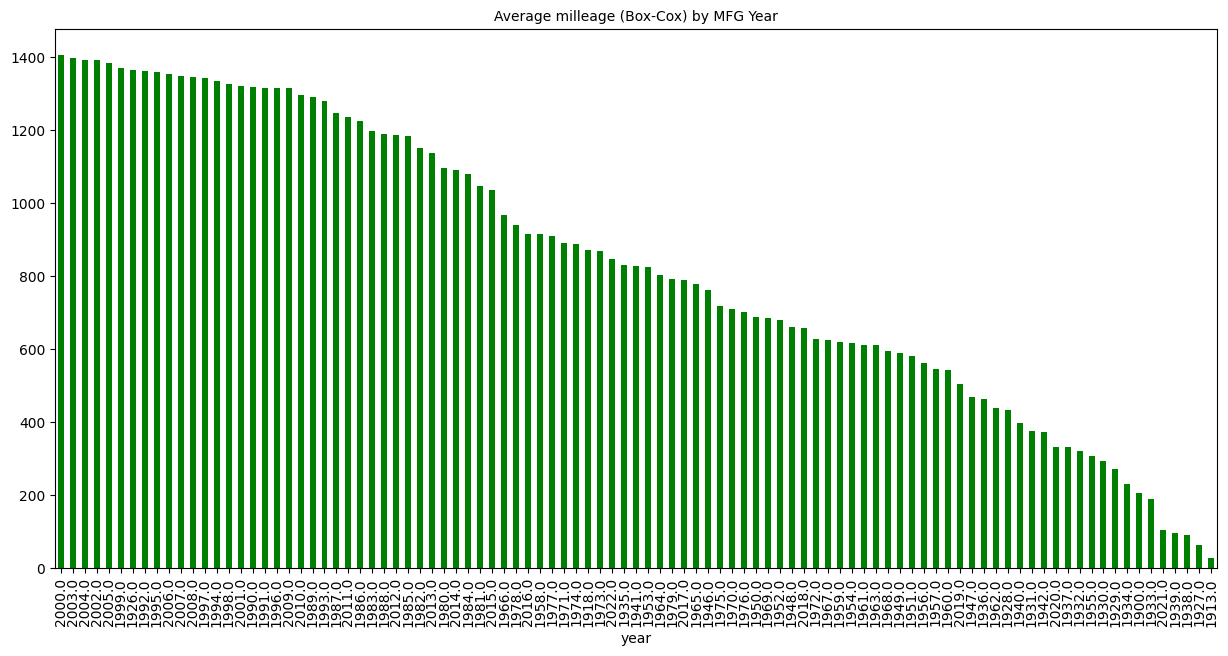

In [120]:
# Create a new figure with the specified figsize
plt.figure(figsize = (15, 7))

# Group by "manufacturer" and calculate the mean price for each group
ca_vehicles.groupby("year")["odometer"].mean().sort_values(ascending=False).plot(kind="bar", fontsize=10, color="green")
plt.title("Average milleage (Box-Cox) by MFG Year", fontsize=10)

# Show the plot
plt.show()

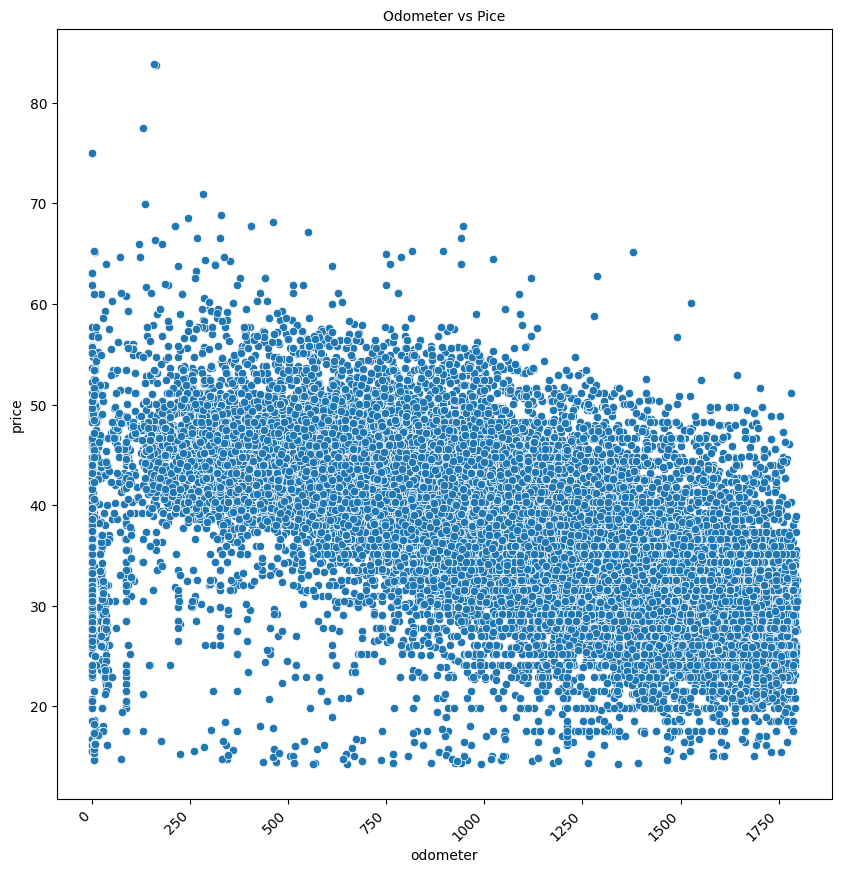

In [121]:
#visualizing effects of Odometer on Price
plt.figure(figsize = (10, 10))
sns.scatterplot(x = ca_vehicles.odometer, y = ca_vehicles.price, palette = "Set1")
plt.title("Odometer vs Pice", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()


In [122]:
ca_vehicles['year'].describe()

count    38565.000000
mean      2011.261507
std          9.514061
min       1900.000000
25%       2008.000000
50%       2014.000000
75%       2017.000000
max       2022.000000
Name: year, dtype: float64

In [123]:
#dropping cars older than 20 years from the mean as cars that are older than 20-25years are considered "classic".
# classic cars prices typically increases with as they get older as they become rarer and collectible items.
ca_vehicles = ca_vehicles[(ca_vehicles['year'] > 1997)] 
ca_vehicles['year'].describe()

count    36867.000000
mean      2012.808175
std          5.241681
min       1998.000000
25%       2009.000000
50%       2014.000000
75%       2017.000000
max       2022.000000
Name: year, dtype: float64

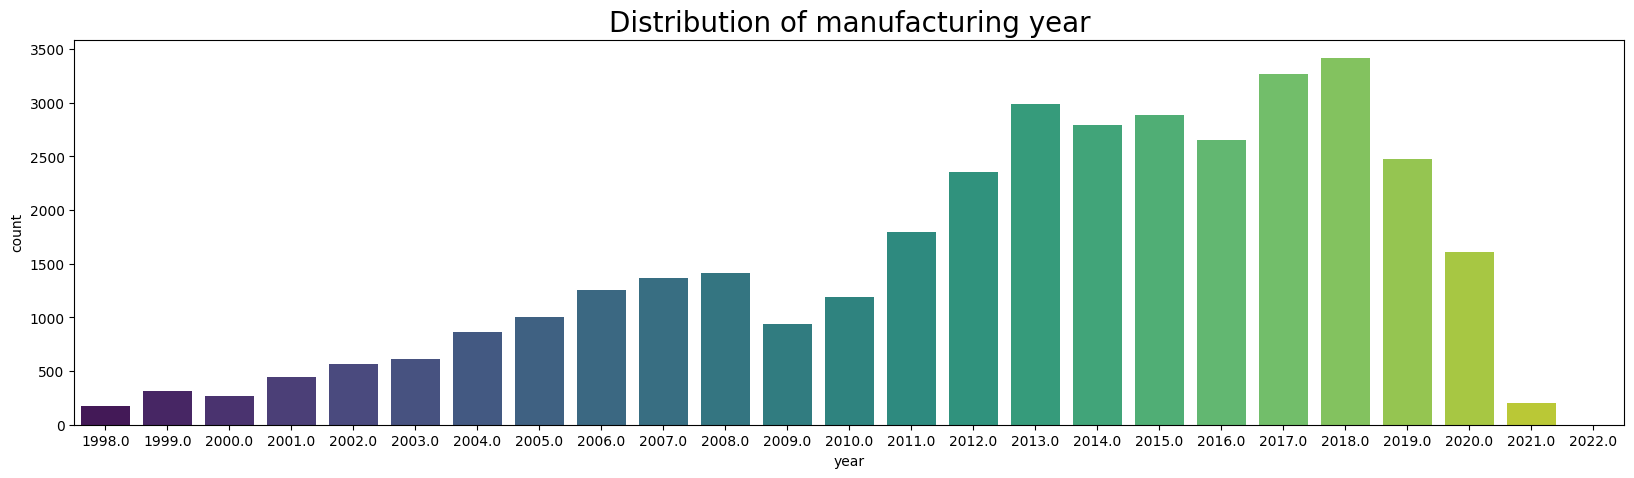

In [124]:
#visualizing the "year" column
plt.figure(figsize = (20, 5))
sns.countplot(x = ca_vehicles.year, palette = "viridis")
plt.title("Distribution of manufacturing year", fontsize = 20)
plt.show()

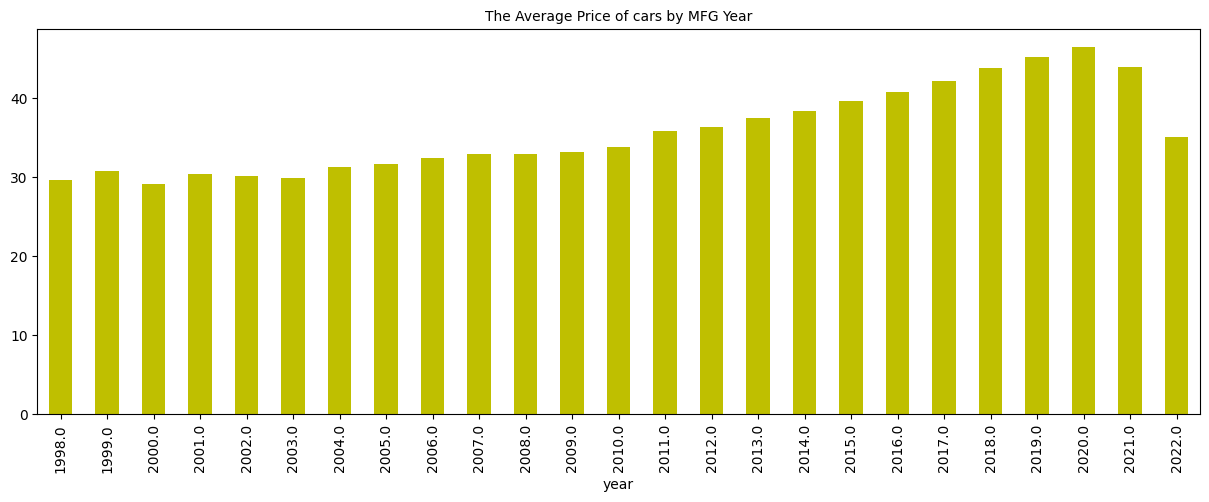

In [125]:
#Visualizing effects of MFG year on price
plt.figure(figsize = (15, 5))
ca_vehicles.groupby('year')['price'].mean().plot(kind = 'bar', color = 'y')
plt.title("The Average Price of cars by MFG Year", fontsize = 10)
plt.show()

In [126]:
#creating a column "age" 
ca_vehicles['present year'] = 2022.5
ca_vehicles['age'] = ca_vehicles['present year'] - ca_vehicles['year']
ca_vehicles.drop(['present year'], inplace = True, axis = 1)

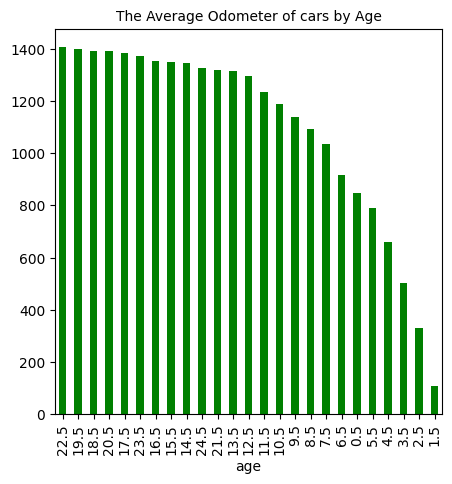

In [127]:
#visualizing effects on conditions on price
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('age')['odometer'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Odometer of cars by Age", fontsize = 10)
plt.show()

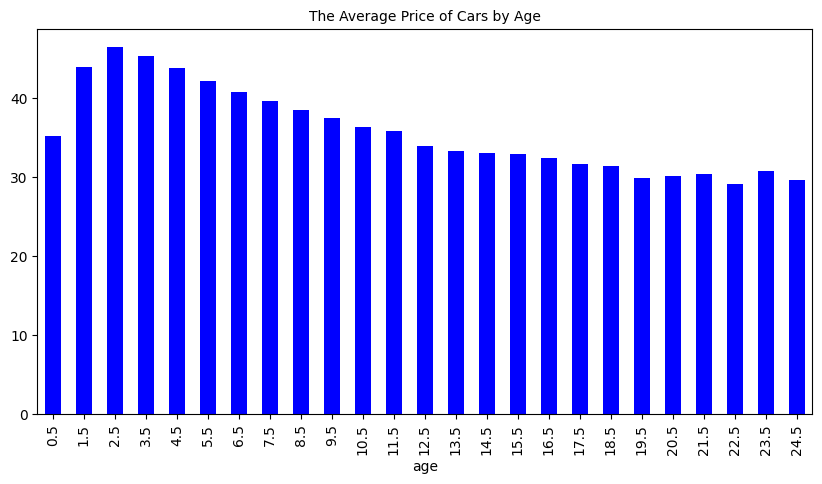

In [128]:
#Visualizing effects of MFG year on price
plt.figure(figsize = (10, 5))
ca_vehicles.groupby('age')['price'].mean().plot(kind = 'bar', color = 'b')
plt.title("The Average Price of Cars by Age", fontsize = 10)
plt.show()

In [129]:
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36867 entries, 0 to 50613
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         36867 non-null  float64
 1   year          36867 non-null  float64
 2   manufacturer  36867 non-null  object 
 3   condition     26199 non-null  object 
 4   fuel          36827 non-null  object 
 5   odometer      36867 non-null  float64
 6   title_status  35545 non-null  object 
 7   transmission  36766 non-null  object 
 8   type          30931 non-null  object 
 9   paint_color   25988 non-null  object 
 10  model         36867 non-null  object 
 11  age           36867 non-null  float64
dtypes: float64(4), object(8)
memory usage: 3.7+ MB


Text(0.5, 1.0, 'Distribution of cars condition')

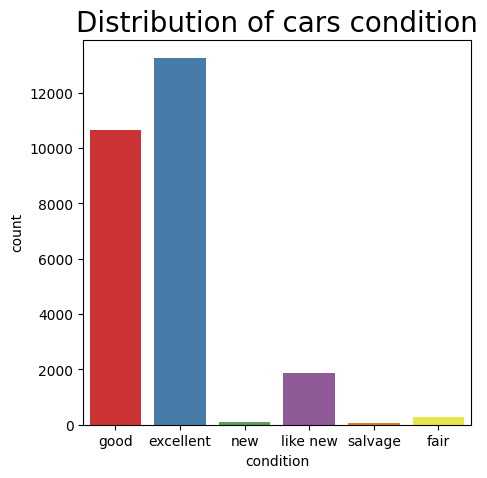

In [130]:
#visualizing car conditon column
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.condition, palette = "Set1")
plt.title("Distribution of cars condition", fontsize = 20)

In [131]:
# Impute missing values in column 'condition' with average condition of "good" 
ca_vehicles['condition'].fillna("good", inplace=True)
ca_vehicles['condition'].value_counts()

condition
good         21318
excellent    13258
like new      1886
fair           271
new             85
salvage         49
Name: count, dtype: int64

In [132]:
#dropping the "salvage" conditions:
ca_vehicles = ca_vehicles[ca_vehicles['condition'] != "salvage"]
ca_vehicles['condition'].value_counts()

condition
good         21318
excellent    13258
like new      1886
fair           271
new             85
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of cars condition')

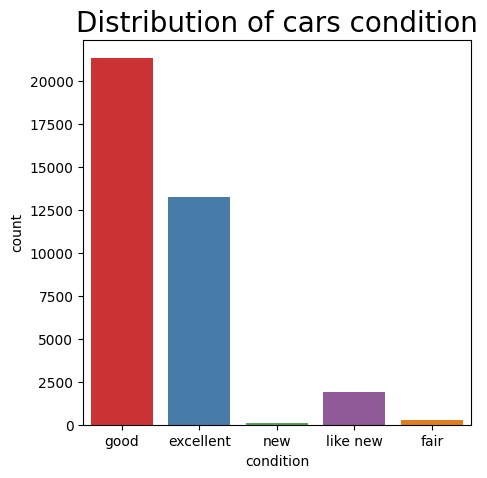

In [133]:
#visualizing the condition column
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.condition, palette = "Set1")
plt.title("Distribution of cars condition", fontsize = 20)

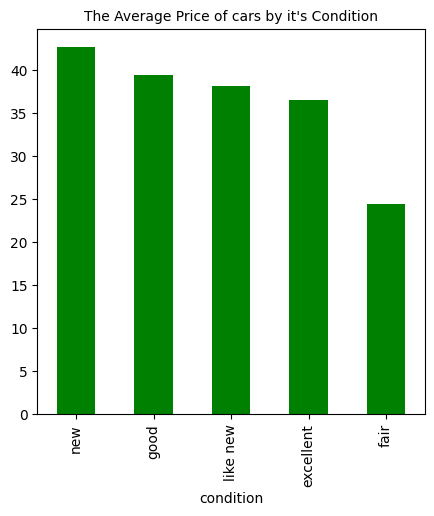

In [134]:
#visualizing effects on conditions on price
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('condition')['price'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars by it's Condition", fontsize = 10)
plt.show()

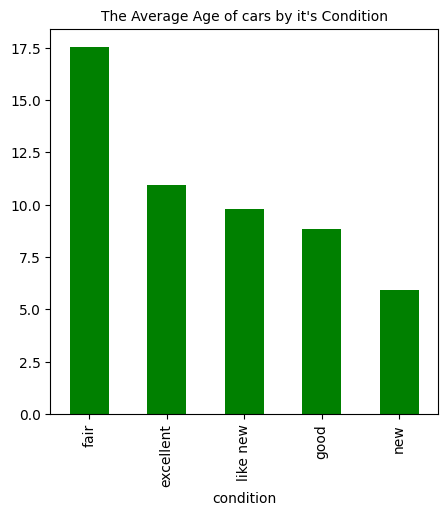

In [135]:
#visualizing effects on conditions on price
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('condition')['age'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Age of cars by it's Condition", fontsize = 10)
plt.show()

In [137]:
ca_vehicles['title_status'].value_counts()

title_status
clean         34547
salvage         718
rebuilt         153
lien             65
missing           9
parts only        4
Name: count, dtype: int64

In [138]:
# Impute missing values in column 'title' with of "clean" 
ca_vehicles['title_status'].fillna("clean", inplace=True)

# Dropping all titles "rebuilt", "salvage", "missing", 'lien', 
# "parts only" as the are indicators that there might be issues with the car and it's safety.
make_to_drop = ["rebuilt", "salvage", "lien", "missing", "parts only"]
ca_vehicles = ca_vehicles[~ca_vehicles['title_status'].isin(make_to_drop)]

ca_vehicles['title_status'].value_counts()


title_status
clean    35869
Name: count, dtype: int64

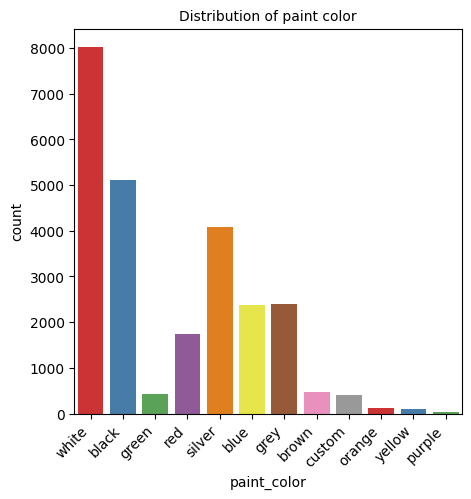

In [139]:
#visualizing paint color distribution
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.paint_color, palette = "Set1")
plt.title("Distribution of paint color", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()

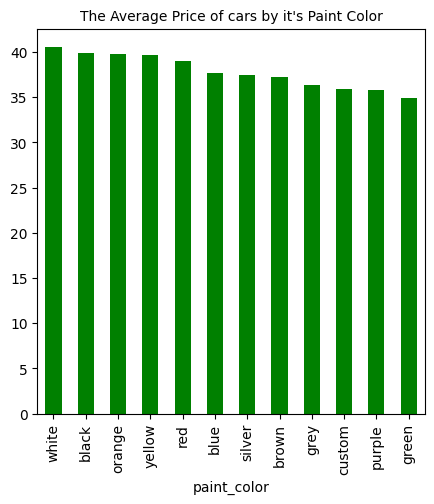

In [140]:
#what are the effects of paint color on price?
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('paint_color')['price'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars by it's Paint Color", fontsize = 10)
plt.show()

In [141]:
# Impute missing values in column 'paint color' with average condition of "unknown" 
ca_vehicles['paint_color'].fillna("unknown", inplace=True)
ca_vehicles['paint_color'].value_counts()

paint_color
unknown    10587
white       8020
black       5102
silver      4092
grey        2398
blue        2382
red         1731
brown        467
green        429
custom       407
orange       117
yellow       108
purple        29
Name: count, dtype: int64

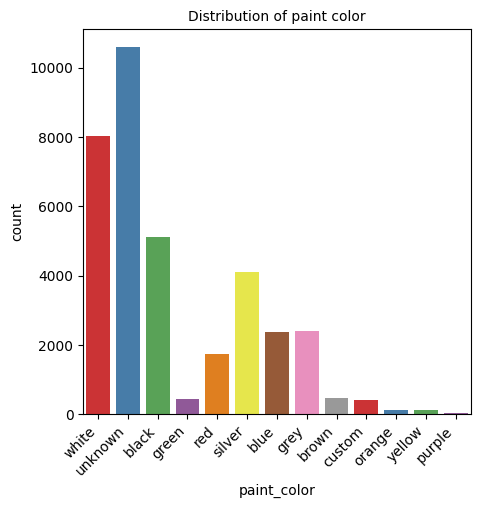

In [142]:
#visualizing paint color distribution with new class of "unknown color"
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.paint_color, palette = "Set1")
plt.title("Distribution of paint color", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()

In [143]:
ca_vehicles['transmission'].value_counts()

transmission
automatic    27860
other         6193
manual        1715
Name: count, dtype: int64

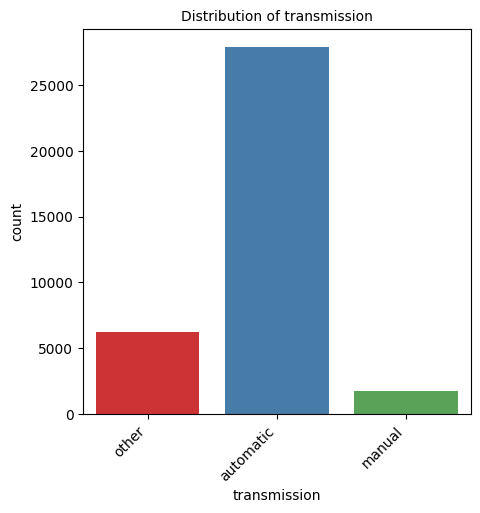

In [144]:
#visualizing transmission distribution
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.transmission, palette = "Set1")
plt.title("Distribution of transmission", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()

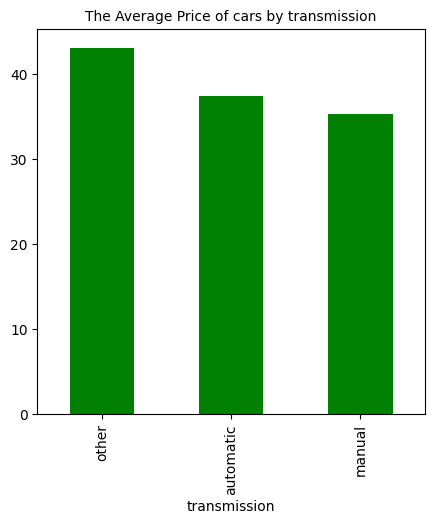

In [145]:
#what are the effects of transmission on price?
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('transmission')['price'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars by transmission", fontsize = 10)
plt.show()

In [146]:
# Impute missing values in column 'transmission' with average condition of "other" in order to preserve data 
ca_vehicles['transmission'].fillna('other', inplace=True)
ca_vehicles['transmission'].value_counts()

transmission
automatic    27860
other         6294
manual        1715
Name: count, dtype: int64

In [147]:
ca_vehicles['type'].value_counts()

type
sedan          9490
SUV            6143
pickup         3858
other          2280
hatchback      2112
truck          1792
coupe          1685
wagon          1043
van             814
convertible     744
mini-van        291
offroad          47
bus              14
Name: count, dtype: int64

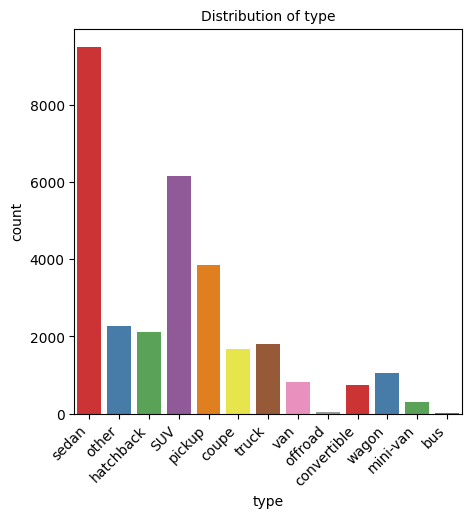

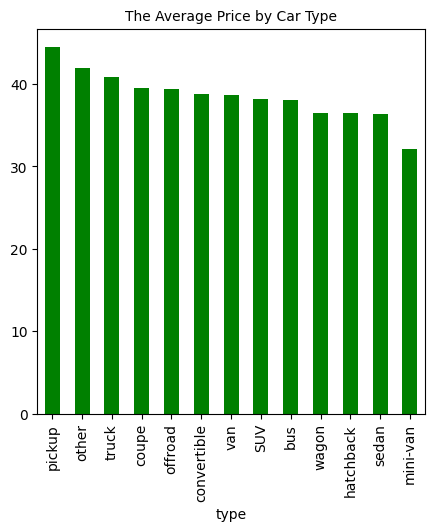

In [148]:
#visualizing transmission distribution
plt.figure(figsize = (5, 5))
sns.countplot(x = ca_vehicles.type, palette = "Set1")
plt.title("Distribution of type", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()

#what are the effects of transmission on price?
plt.figure(figsize = (5, 5))
ca_vehicles.groupby('type')['price'].mean().sort_values(ascending=False).plot(kind = 'bar', color = 'g')
plt.title("The Average Price by Car Type", fontsize = 10)
plt.show()

In [149]:
# Impute missing values in column 'transmission' with average condition of "other" in order to preserve data 
ca_vehicles['type'].fillna('other', inplace=True)
ca_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35869 entries, 0 to 50613
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         35869 non-null  float64
 1   year          35869 non-null  float64
 2   manufacturer  35869 non-null  object 
 3   condition     35869 non-null  object 
 4   fuel          35829 non-null  object 
 5   odometer      35869 non-null  float64
 6   title_status  35869 non-null  object 
 7   transmission  35869 non-null  object 
 8   type          35869 non-null  object 
 9   paint_color   35869 non-null  object 
 10  model         35869 non-null  object 
 11  age           35869 non-null  float64
dtypes: float64(4), object(8)
memory usage: 3.6+ MB


In [150]:
ca_vehicles.to_csv('ca_vehicles_clean.csv')


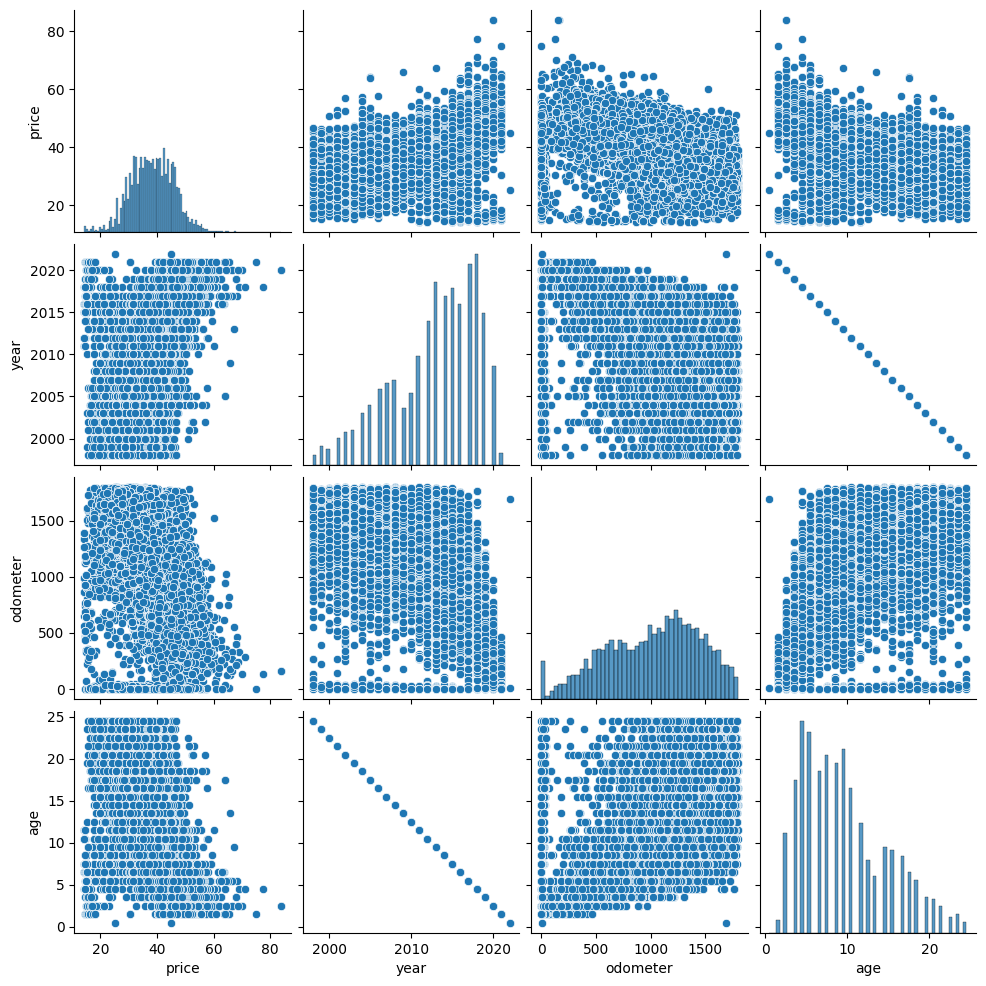

In [151]:
sns.pairplot(ca_vehicles)

In [152]:
#using target encoder to transform manufacturer and make columns
%pip install category_encoders
from category_encoders import TargetEncoder

Note: you may need to restart the kernel to use updated packages.


In [153]:
ca_vehicles_b = ca_vehicles

In [154]:
# Define and fit the target encoder for the 'manufacturer' column

ca_vehicles_encoded = pd.DataFrame()
encoder_manufacturer = TargetEncoder(cols=['manufacturer'])
ca_vehicles_encoded['manufacturer'] = encoder_manufacturer.fit_transform(ca_vehicles['manufacturer'], ca_vehicles['price'])

# Define and fit the target encoder for the 'model' column
encoder_model = TargetEncoder(cols='model')
ca_vehicles_encoded['model'] = encoder_model.fit_transform(ca_vehicles['model'], ca_vehicles['price'])

ca_vehicles_encoded.head()

,manufacturer,model
0,35.099434,32.782301
1,37.157556,37.890560
7,39.109131,44.000778
8,35.486125,37.383911
9,41.937280,40.676283


In [155]:
# Define and fit the target encoder for the 'manufacturer' column
encoder_manufacturer = TargetEncoder(cols=['manufacturer'])
ca_vehicles['manufacturer_te'] = encoder_manufacturer.fit_transform(ca_vehicles['manufacturer'], ca_vehicles['price'])

# Define and fit the target encoder for the 'model' column
encoder_model = TargetEncoder(cols='model')
ca_vehicles['model_te'] = encoder_model.fit_transform(ca_vehicles['model'], ca_vehicles['price'])
ca_vehicles.head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,paint_color,model,age,manufacturer_te,model_te
0,38.605461,2018.0,hyundai,good,gas,440.913316,clean,other,sedan,white,accent,4.5,35.099434,32.782301
1,25.560669,2004.0,toyota,good,gas,1478.446445,clean,automatic,other,unknown,highlander,18.5,37.157556,37.890560
7,43.851891,2018.0,acura,good,gas,490.601525,clean,other,sedan,black,tlx,4.5,39.109131,44.000778
8,41.321337,2018.0,volkswagen,good,gas,271.421877,clean,other,other,green,tiguan,4.5,35.486125,37.383911
9,41.614499,2018.0,gmc,good,gas,653.925932,clean,other,other,unknown,terrain,4.5,41.937280,40.676283


In [156]:
ca_vehicles.head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,paint_color,model,age,manufacturer_te,model_te
0,38.605461,2018.0,hyundai,good,gas,440.913316,clean,other,sedan,white,accent,4.5,35.099434,32.782301
1,25.560669,2004.0,toyota,good,gas,1478.446445,clean,automatic,other,unknown,highlander,18.5,37.157556,37.890560
7,43.851891,2018.0,acura,good,gas,490.601525,clean,other,sedan,black,tlx,4.5,39.109131,44.000778
8,41.321337,2018.0,volkswagen,good,gas,271.421877,clean,other,other,green,tiguan,4.5,35.486125,37.383911
9,41.614499,2018.0,gmc,good,gas,653.925932,clean,other,other,unknown,terrain,4.5,41.937280,40.676283


In [157]:
ca_vehicles_te = ca_vehicles

In [158]:
ca_vehicles_te.head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,paint_color,model,age,manufacturer_te,model_te
0,38.605461,2018.0,hyundai,good,gas,440.913316,clean,other,sedan,white,accent,4.5,35.099434,32.782301
1,25.560669,2004.0,toyota,good,gas,1478.446445,clean,automatic,other,unknown,highlander,18.5,37.157556,37.890560
7,43.851891,2018.0,acura,good,gas,490.601525,clean,other,sedan,black,tlx,4.5,39.109131,44.000778
8,41.321337,2018.0,volkswagen,good,gas,271.421877,clean,other,other,green,tiguan,4.5,35.486125,37.383911
9,41.614499,2018.0,gmc,good,gas,653.925932,clean,other,other,unknown,terrain,4.5,41.937280,40.676283


In [159]:
#dropping the non-encoded manufacturer and model columns
columns=["manufacturer", "model"]
ca_vehicles_te = ca_vehicles_te.drop(columns = columns, axis = 1)
#ca_vehicles_te.rename(columns={"manufacturer_te": "manufacturer", "model_te": "model"}, inplace=True)
ca_vehicles_te.head()

,price,year,condition,fuel,odometer,title_status,transmission,type,paint_color,age,manufacturer_te,model_te
0,38.605461,2018.0,good,gas,440.913316,clean,other,sedan,white,4.5,35.099434,32.782301
1,25.560669,2004.0,good,gas,1478.446445,clean,automatic,other,unknown,18.5,37.157556,37.890560
7,43.851891,2018.0,good,gas,490.601525,clean,other,sedan,black,4.5,39.109131,44.000778
8,41.321337,2018.0,good,gas,271.421877,clean,other,other,green,4.5,35.486125,37.383911
9,41.614499,2018.0,good,gas,653.925932,clean,other,other,unknown,4.5,41.937280,40.676283


In [160]:
#renaming manufacturer_te and model_te columns
ca_vehicles_te.rename(columns={"manufacturer_te": "manufacturer", "model_te": "model"}, inplace=True)
ca_vehicles_te.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35869 entries, 0 to 50613
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         35869 non-null  float64
 1   year          35869 non-null  float64
 2   condition     35869 non-null  object 
 3   fuel          35829 non-null  object 
 4   odometer      35869 non-null  float64
 5   title_status  35869 non-null  object 
 6   transmission  35869 non-null  object 
 7   type          35869 non-null  object 
 8   paint_color   35869 non-null  object 
 9   age           35869 non-null  float64
 10  manufacturer  35869 non-null  float64
 11  model         35869 non-null  float64
dtypes: float64(6), object(6)
memory usage: 3.6+ MB


In [161]:
#getting dummines for non-numerical columns (should have called it )
ca_vehicles_encoded = pd.get_dummies(ca_vehicles_te, columns=["condition", "fuel", "title_status", "transmission", "type", "paint_color"])

#verifying
ca_vehicles_encoded.head()

,price,year,odometer,age,manufacturer,model,condition_excellent,condition_fair,condition_good,condition_like new,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
0,38.605461,2018.0,440.913316,4.5,35.099434,32.782301,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,25.560669,2004.0,1478.446445,18.5,37.157556,37.890560,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
7,43.851891,2018.0,490.601525,4.5,39.109131,44.000778,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,41.321337,2018.0,271.421877,4.5,35.486125,37.383911,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
9,41.614499,2018.0,653.925932,4.5,41.937280,40.676283,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [162]:
#generate train/test data for ca_vehivles
X = ca_vehicles_encoded.drop(['price'], axis = 1)
y = ca_vehicles_encoded['price']
# removing duplicates from 'y'
#y = y.loc[:, ~y.columns.duplicated()]

#verifying X and y
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#verifying X_train and y_train
print(len(X_train))
print(len(y_test))
print(y_train.shape)
print(y_test.shape)
y_train.head()

(35869, 45)
(35869,)
25108
10761
(25108,)
(10761,)


42246    36.674514
24298    30.327409
15395    39.198421
10373    29.063258
13003    26.473879
Name: price, dtype: float64

In [163]:
X_train.head()

,year,odometer,age,manufacturer,model,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
42246,2012.0,709.094192,10.5,38.649725,36.895859,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
24298,2012.0,1418.349064,10.5,35.099434,32.967534,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
15395,2016.0,807.421652,6.5,35.194945,34.035409,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
10373,2011.0,1255.225760,11.5,39.473423,33.332649,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
13003,2004.0,1659.424070,18.5,35.194945,31.807587,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [164]:
from sklearn.pipeline import Pipeline

In [165]:
#Sequential Feature selector pipeline with 3 features:
pipe = Pipeline([("column_selector", SequentialFeatureSelector(estimator = LinearRegression(), scoring = 'neg_mean_squared_error', n_features_to_select = 3, direction = "forward")
), ("linred", LinearRegression())])
pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds_3f = pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds_3f)

# Answer check
print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')
pipe

Train MSE:  19.59
Test MSE:  18.49


Pipeline(steps=[('column_selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=3,
                                           scoring='neg_mean_squared_error')),
                ('linred', LinearRegression())])

In [166]:
#extracting the features selected by the model.
selected_features_mask = pipe.named_steps['column_selector'].get_support()

# Get the names of the selected features
selected_features = X_train.columns[selected_features_mask]

print("Selected features:", selected_features)

Selected features: Index(['odometer', 'age', 'model'], dtype='object')


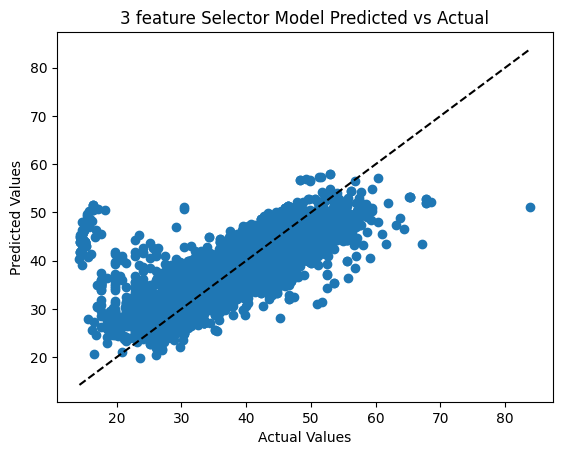

In [167]:
# Plot the 3 feature Selector Model predicted vs actual values
plt.scatter(y_test, test_preds_3f)
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')
plt.title('3 feature Selector Model Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [168]:
#creating a selector pipeline with linear regressor
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])
selector_pipe

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression())),
                ('model', LinearRegression())])

In [169]:
#Applying gridsearchCV to select best n-features:
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds_nf = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds_nf)

selected_features_mask = selector_grid.best_estimator_.named_steps['selector'].get_support()

# Get the names of the selected features
selected_features = X_train.columns[selected_features_mask]

print("Selected features:", selected_features)

# printing the best MSE
print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')


Selected features: Index(['odometer', 'age', 'model', 'condition_fair', 'fuel_diesel'], dtype='object')
Train MSE: 19.014886869265368
Test MSE: 17.8132568056569


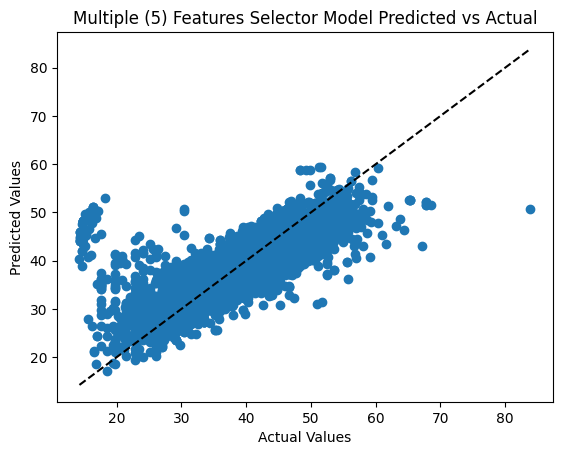

In [170]:
# Plot the Ridge Regressor predicted vs actual values
plt.scatter(y_test, test_preds_nf)
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')
plt.title('Multiple (5) Features Selector Model Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [171]:
#Printing # features Vs MSE:

# Extract number of features and corresponding mean squared errors
n_features = [params['selector__n_features_to_select'] for params in selector_grid.cv_results_['params']]
mean_squared_errors = selector_grid.cv_results_['mean_test_score']

# Print number of features vs. MSE
for num_features, mse in zip(n_features, mean_squared_errors):
    print(f'Number of Features: {num_features}, MSE: {mse:.2f}')


Number of Features: 2, MSE: 0.63
Number of Features: 3, MSE: 0.66
Number of Features: 4, MSE: 0.66
Number of Features: 5, MSE: 0.67


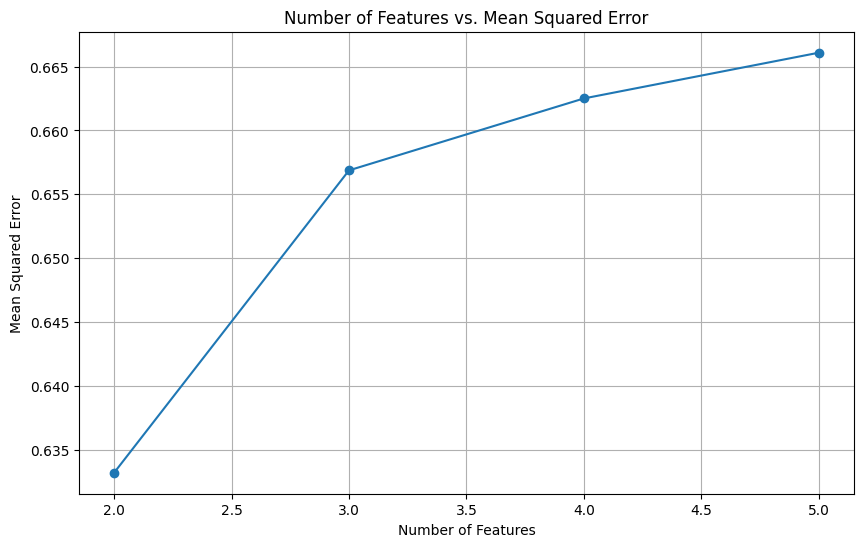

In [172]:
#Plotting #features Vs MSE

# Extract number of features and corresponding mean squared errors
n_features = [params['selector__n_features_to_select'] for params in selector_grid.cv_results_['params']]
mean_squared_errors = selector_grid.cv_results_['mean_test_score']

# Plot number of features vs. MSEs
plt.figure(figsize=(10, 6))
plt.plot(n_features, mean_squared_errors, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('Number of Features vs. Mean Squared Error')
plt.grid(True)
plt.show()


In [173]:
#extracting feature parameters
best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_


# printing features
print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('model', LinearRegression())])
Features from best selector: Index(['odometer', 'age', 'model', 'condition_fair', 'fuel_diesel'], dtype='object').
Coefficient values: 


,odometer,age,model,condition_fair,fuel_diesel
model,-0.00371,-0.554558,0.843563,-6.300303,2.69708


In [174]:
params_dict = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
test_preds_ridge_1 = grid.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds_ridge_1)

In [175]:
# print MSEs
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 18.006181842139906
Test MSE: 16.990101274034245


In [176]:
#Best Alpha Value
best_alpha = grid.best_params_
print(f'Best alpha: {list(best_alpha.values())[0]}')

Best alpha: 10.0


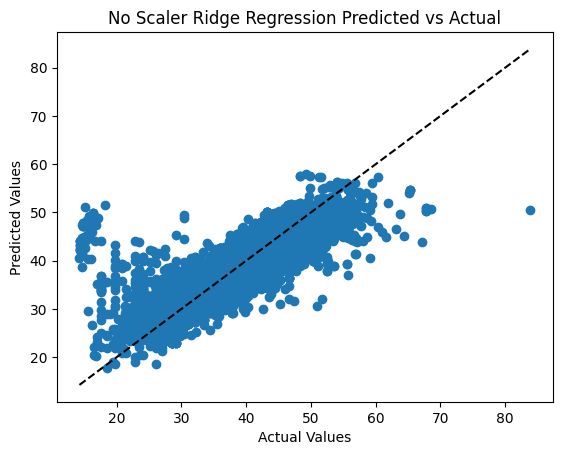

In [177]:
# Plot the Ridge Regressor predicted vs actual values
plt.scatter(y_test, test_preds_ridge_1)
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')
plt.title('No Scaler Ridge Regression Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [178]:
#creating a Pipeline to scale and apply Ridge regressor.
pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid_2 = ''
model_2_train_mse = ''
model_2_test_mse = ''
model_2_best_alpha = ''

#Creating a Grid Search to find thebest Alpha and test MSE
grid_2 = GridSearchCV(pipe, param_grid=param_dict)
grid_2.fit(X_train, y_train)
train_preds = grid_2.predict(X_train)
test_preds = grid_2.predict(X_test)
model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)
model_2_best_alpha = grid_2.best_params_


# printing parameters
print(f'Test MSE: {model_2_test_mse}')
print(f'Best Alpha: {list(model_2_best_alpha.values())[0]}')

Test MSE: 16.98979803291837
Best Alpha: 10.0


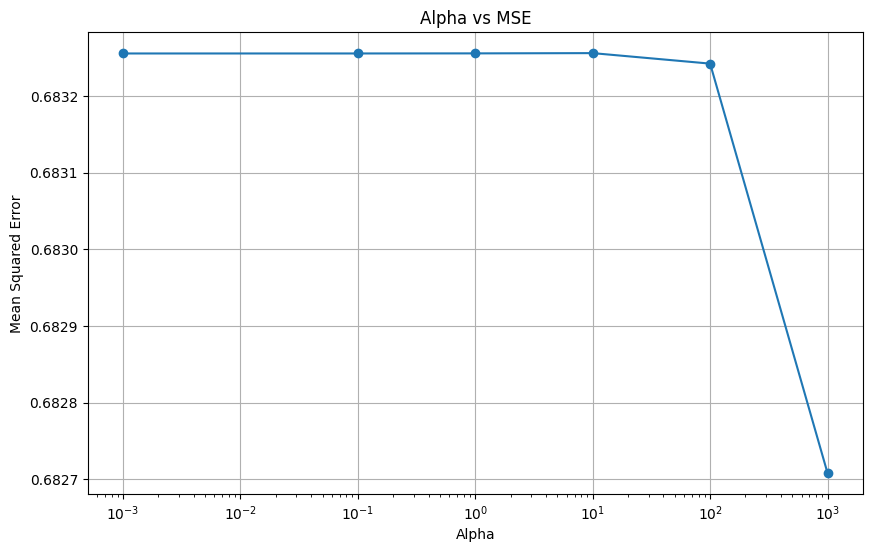

In [179]:
# Extract alpha values and corresponding mean squared errors
alphas = [params['ridge__alpha'] for params in grid_2.cv_results_['params']]
mean_squared_errors = grid_2.cv_results_['mean_test_score']

# Plot alpha vs MSE
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_squared_errors, marker='o')
plt.xscale('log')  # Set log scale for alpha values
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Alpha vs MSE')
plt.grid(True)
plt.show()


In [180]:
# Get the best estimator (pipeline) from the grid search
best_estimator = grid_2.best_estimator_

# Access the Ridge estimator from the pipeline
ridge_estimator = best_estimator.named_steps['ridge']

# Get the coefficients
coefficients = ridge_estimator.coef_

# Convert coefficients array to pandas DataFrame
coefficients_df = pd.DataFrame({'Coefficient': coefficients})

# Save coefficients DataFrame to CSV
coefficients_df.to_csv("ca_ridges_coef.csv", index=True)

print("Coefficients:", coefficients)


Coefficients: [ 1.4847112  -1.57363606 -1.4847112   0.38902904  2.98894245 -0.03777693
 -0.49102872  0.04507134  0.15438085  0.02301693  0.1653835  -0.32370337
 -0.7761829  -0.32054738 -0.4103489   0.         -0.05281387  0.08212134
  0.01182992  0.16919485  0.02016461  0.32324037  0.07734962 -0.36024914
 -0.04406349  0.04305245 -0.00909658  0.39505394 -0.24330336 -0.16265343
 -0.02421512 -0.06722858  0.12385262  0.02433353  0.00500157  0.0481105
 -0.02410656  0.02534532 -0.01453156 -0.01209616  0.04750483  0.04654326
 -0.35768397  0.19383591 -0.00311879]


In [181]:
# Extract the best Ridge model from grid search results
#best_ridge_model = grid_2.best_estimator_.named_steps['ridge']

# Calculate permutation importance
perm_importance = permutation_importance(ridge_estimator, X_test, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X_train.columns

# Print permutation importance for each feature
print("Permutation Importance:")
for i, feature in enumerate(feature_names):
    importance = perm_importance.importances_mean[i]
    print(f"{feature}: {importance}")

Permutation Importance:
year: -121.1965310525724
odometer: -203.51423266203784
age: -121.19653105249017
manufacturer: -2.066203573474195
model: -61.269549698638
condition_excellent: -0.08186813076827093
condition_fair: -0.07350408243437415
condition_good: -0.102783963237016
condition_like new: 0.0026212173208477905
condition_new: -0.0012227547689690255
fuel_diesel: 0.01866451367022819
fuel_electric: 0.05322815972394892
fuel_gas: -1.0124418027771753
fuel_hybrid: 0.0030238381878007203
fuel_other: 0.5158278779155807
title_status_clean: 0.0
transmission_automatic: -0.19069356649415567
transmission_manual: 0.0324687661282951
transmission_other: -0.047392749241407725
type_SUV: 0.10182825411102385
type_bus: 0.00012195081944810227
type_convertible: -0.016933072829124284
type_coupe: -0.018525660440354842
type_hatchback: 0.1766691312477633
type_mini-van: -0.005144231708982261
type_offroad: 0.00024302366655319928
type_other: -0.0032284282460750546
type_pickup: -0.111729811301484
type_sedan: 0.075

In [182]:
# Extract feature names 
feature_names = list(X_train.columns)

# Get importances
perm_importance = permutation_importance(ridge_estimator, X_test, y_test)

# Check lengths match 
assert len(feature_names) == len(perm_importance.importances_mean)

# Create DataFrame
perm_importance_df = pd.DataFrame({
  'Feature': feature_names,
  'Permutation_Importance': perm_importance.importances_mean 
})

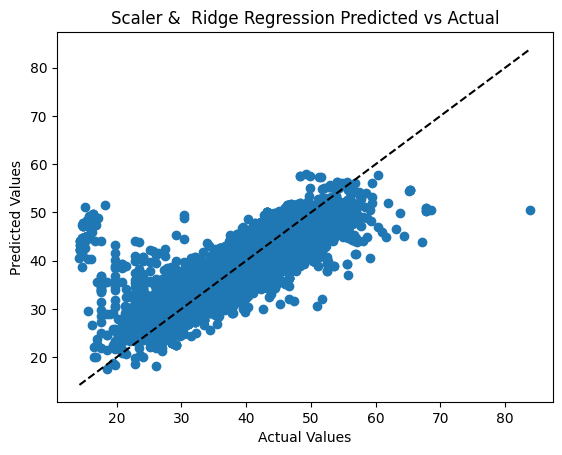

In [183]:
# Plot the Ridge Regressor predicted vs actual values
plt.scatter(y_test, test_preds)
plt.xlabel('Actual Values')  
plt.ylabel('Predicted Values')
plt.title('Scaler &  Ridge Regression Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [188]:
# Accessing the best estimator from the grid search object
best_estimator = grid_2.best_estimator_

# Accessing the Ridge estimator from the best estimator
ridge_estimator = best_estimator.named_steps['ridge']

# Getting the coefficients
coefficients = ridge_estimator.coef_

# Crteate a Panda series and print or use coefficients:
coef_series = pd.Series(ridge_estimator.coef_, index=feature_names)
print(coef_series)

# Sort coef_series in descending order of coefficients
coef_series_sorted = coef_series.sort_values(ascending=False) 

# save and print sorted coef_series
coef_series_sorted.to_csv('ridge_model_coefficients.csv')
print(coef_series_sorted)


year                      1.484711
odometer                 -1.573636
age                      -1.484711
manufacturer              0.389029
model                     2.988942
condition_excellent      -0.037777
condition_fair           -0.491029
condition_good            0.045071
condition_like new        0.154381
condition_new             0.023017
fuel_diesel               0.165384
fuel_electric            -0.323703
fuel_gas                 -0.776183
fuel_hybrid              -0.320547
fuel_other               -0.410349
title_status_clean        0.000000
transmission_automatic   -0.052814
transmission_manual       0.082121
transmission_other        0.011830
type_SUV                  0.169195
type_bus                  0.020165
type_convertible          0.323240
type_coupe                0.077350
type_hatchback           -0.360249
type_mini-van            -0.044063
type_offroad              0.043052
type_other               -0.009097
type_pickup               0.395054
type_sedan          

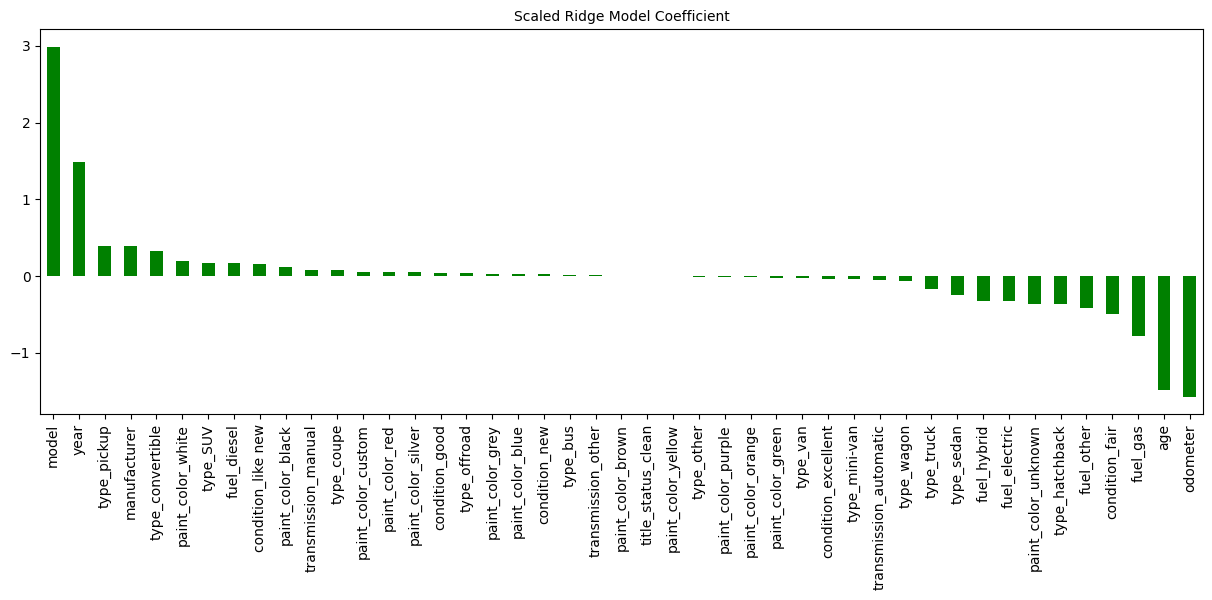

In [193]:
plt.figure(figsize = (15, 5))
coef_series_sorted.plot(kind = 'bar', color = 'g')
plt.title("Scaled Ridge Model Coefficient", fontsize = 10)
plt.show()
